# Petfinder EDA

## Set Path and import libraries

In [1]:
import os 
import json
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score,  make_scorer
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

def squared_cohen_kappa(y1, y2):
    return cohen_kappa_score(y1,y2)**2

DATA_PATH = '../../../Dataset/petfinder'
print(os.listdir('../../../Dataset/petfinder'))

['breed_labels.csv', 'color_labels.csv', 'state_labels.csv', 'test.zip', 'test_images.zip', 'test_metadata.zip', 'test_sentiment.zip', 'train', 'train_images', 'train_metadata', 'train_sentiment']


## Import Data

In [2]:
df = pd.read_csv(DATA_PATH+'/train/train.csv')
train_id = df['PetID']

sentiment_mag = []
sentiment_score = []
for pet in train_id:
    try:
        with open(DATA_PATH+'/train_sentiment/' + pet + '.json', 'r') as f:
            sentiment = json.load(f)
            #print(DATA_PATH+'/train_sentiment/' + pet + '.json')
        sentiment_mag.append(sentiment['documentSentiment']['magnitude'])
        sentiment_score.append(sentiment['documentSentiment']['score'])
    except FileNotFoundError:
        sentiment_mag.append(-1)
        sentiment_score.append(-1)

    
df.loc[:, 'sentiment_mag'] = sentiment_mag
df.loc[:, 'sentiment_score'] = sentiment_score

df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,sentiment_mag,sentiment_score
0,2,Nibble,3,299,0,1,1,7,0,1,...,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,2.4,0.3
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,0.7,-0.2
2,1,Brisco,1,307,0,1,2,7,0,2,...,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,3.7,0.2
3,1,Miko,4,307,0,2,1,2,0,2,...,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,0.9,0.9
4,1,Hunter,1,307,0,1,1,0,0,2,...,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,3.7,0.6


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 26 columns):
Type               14993 non-null int64
Name               13736 non-null object
Age                14993 non-null int64
Breed1             14993 non-null int64
Breed2             14993 non-null int64
Gender             14993 non-null int64
Color1             14993 non-null int64
Color2             14993 non-null int64
Color3             14993 non-null int64
MaturitySize       14993 non-null int64
FurLength          14993 non-null int64
Vaccinated         14993 non-null int64
Dewormed           14993 non-null int64
Sterilized         14993 non-null int64
Health             14993 non-null int64
Quantity           14993 non-null int64
Fee                14993 non-null int64
State              14993 non-null int64
RescuerID          14993 non-null object
VideoAmt           14993 non-null int64
Description        14981 non-null object
PetID              14993 non-null object
PhotoAm

In [4]:
vertex_xs = []
vertex_ys = []
bounding_confidences = []
bounding_importance_fracs = []
dominant_blues = []
dominant_greens = []
dominant_reds = []
dominant_pixel_fracs = []
dominant_scores = []
label_descriptions = []
label_scores = []

for pet in train_id:
    try:
        with open(DATA_PATH+'/train_metadata/' + pet + '-1.json', 'r') as f:
            data = json.load(f)
        vertex_x = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['x']
        vertex_xs.append(vertex_x)
        vertex_y = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['y']
        vertex_ys.append(vertex_y)
        bounding_confidence = data['cropHintsAnnotation']['cropHints'][0]['confidence']
        bounding_confidences.append(bounding_confidence)
        bounding_importance_frac = data['cropHintsAnnotation']['cropHints'][0].get('importanceFraction', -1)
        bounding_importance_fracs.append(bounding_importance_frac)
        dominant_blue = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['blue']
        dominant_blues.append(dominant_blue)
        dominant_green = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['green']
        dominant_greens.append(dominant_green)
        dominant_red = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['red']
        dominant_reds.append(dominant_red)
        dominant_pixel_frac = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['pixelFraction']
        dominant_pixel_fracs.append(dominant_pixel_frac)
        dominant_score = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['score']
        dominant_scores.append(dominant_score)
        if data.get('labelAnnotations'):
            label_description = data['labelAnnotations'][0]['description']
            label_descriptions.append(label_description)
            label_score = data['labelAnnotations'][0]['score']
            label_scores.append(label_score)
        else:
            label_descriptions.append('nothing')
            label_scores.append(-1)
    except FileNotFoundError:
        vertex_xs.append(-1)
        vertex_ys.append(-1)
        bounding_confidences.append(-1)
        bounding_importance_fracs.append(-1)
        dominant_blues.append(-1)
        dominant_greens.append(-1)
        dominant_reds.append(-1)
        dominant_pixel_fracs.append(-1)
        dominant_scores.append(-1)
        label_descriptions.append('nothing')
        label_scores.append(-1)

df.loc[:, 'vertex_x'] = vertex_xs
df.loc[:, 'vertex_y'] = vertex_ys
df.loc[:, 'bounding_confidence'] = bounding_confidences
df.loc[:, 'bounding_importance'] = bounding_importance_fracs
df.loc[:, 'dominant_blue'] = dominant_blues
df.loc[:, 'dominant_green'] = dominant_greens
df.loc[:, 'dominant_red'] = dominant_reds
df.loc[:, 'dominant_pixel_frac'] = dominant_pixel_fracs
df.loc[:, 'dominant_score'] = dominant_scores
df.loc[:, 'label_description'] = label_descriptions
df.loc[:, 'label_score'] = label_scores

df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,vertex_y,bounding_confidence,bounding_importance,dominant_blue,dominant_green,dominant_red,dominant_pixel_frac,dominant_score,label_description,label_score
0,2,Nibble,3,299,0,1,1,7,0,1,...,479,0.8,1.00,21,20,25,0.393910,0.302789,cat,0.990786
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,376,0.8,1.00,17,24,19,0.261856,0.348178,cat,0.981269
2,1,Brisco,1,307,0,1,2,7,0,2,...,399,0.8,1.00,51,55,61,0.055064,0.333318,dog,0.960457
3,1,Miko,4,307,0,2,1,2,0,2,...,299,0.8,1.00,47,50,54,0.127818,0.136823,dog,0.978698
4,1,Hunter,1,307,0,1,1,0,0,2,...,426,0.8,0.98,21,19,24,0.126334,0.256168,dog,0.984346


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 37 columns):
Type                   14993 non-null int64
Name                   13736 non-null object
Age                    14993 non-null int64
Breed1                 14993 non-null int64
Breed2                 14993 non-null int64
Gender                 14993 non-null int64
Color1                 14993 non-null int64
Color2                 14993 non-null int64
Color3                 14993 non-null int64
MaturitySize           14993 non-null int64
FurLength              14993 non-null int64
Vaccinated             14993 non-null int64
Dewormed               14993 non-null int64
Sterilized             14993 non-null int64
Health                 14993 non-null int64
Quantity               14993 non-null int64
Fee                    14993 non-null int64
State                  14993 non-null int64
RescuerID              14993 non-null object
VideoAmt               14993 non-null int64
Descripti

In the main data set you find about 15k animals incl. Metadata. Although there is additional data (like images for some pets) I'll start analyzing the main dataset since there are already features for creating a baseline with

In [6]:
corr = df.corr()
corr['AdoptionSpeed'].sort_index()

AdoptionSpeed          1.000000
Age                    0.100510
Breed1                 0.107834
Breed2                -0.018642
Color1                -0.044192
Color2                -0.038579
Color3                -0.007014
Dewormed              -0.013210
Fee                   -0.004017
FurLength             -0.091337
Gender                 0.057622
Health                 0.029382
MaturitySize           0.045653
PhotoAmt              -0.023233
Quantity               0.062931
State                  0.013119
Sterilized            -0.083447
Type                  -0.091240
Vaccinated            -0.059043
VideoAmt              -0.000571
bounding_confidence   -0.077077
bounding_importance   -0.077869
dominant_blue         -0.037037
dominant_green        -0.034008
dominant_pixel_frac   -0.076257
dominant_red          -0.030132
dominant_score        -0.081885
label_score           -0.087312
sentiment_mag         -0.002461
sentiment_score        0.038163
vertex_x               0.000685
vertex_y

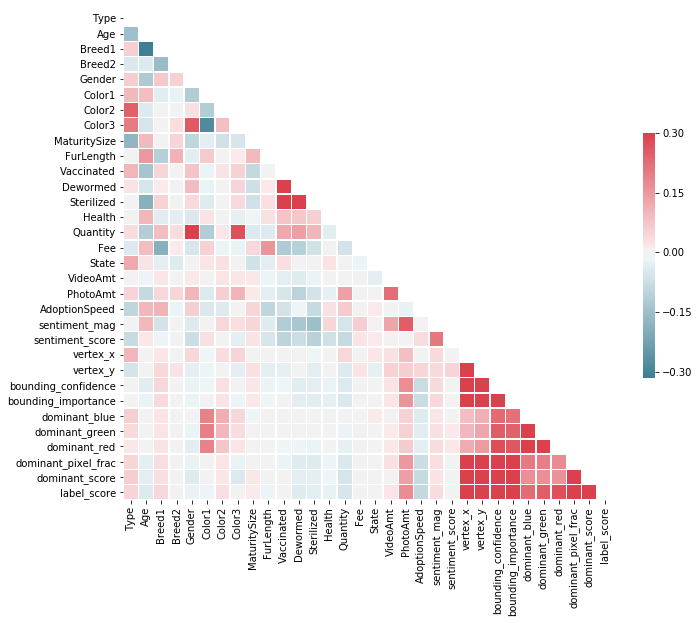

In [7]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

After checking the correlations with our target it looks as if there are no significant correlations between our target and the other features.

## Field Analysis

### Target - Adoption Speed

Contestants are required to predict this value. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way: 
0. Pet was adopted on the same day as it was listed. 
1. Pet was adopted between 1 and 7 days (1st week) after being listed. 
2. Pet was adopted between 8 and 30 days (1st month) after being listed. 
3. Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed. 
4. No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [8]:
target = df['AdoptionSpeed']

Text(0.5,1,'Count of AdoptionSpeed')

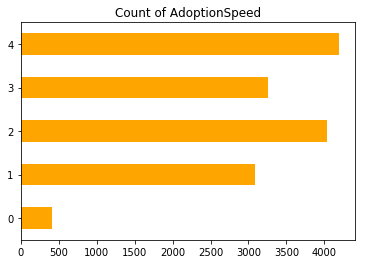

In [9]:
target.value_counts().sort_index().plot('barh', color='orange')
plt.title('Count of AdoptionSpeed')

In [10]:
target.value_counts().sort_index()

0     410
1    3090
2    4037
3    3259
4    4197
Name: AdoptionSpeed, dtype: int64

### Names

In [11]:
print('Most popular names with matching AdoptionSpeed')
for name in df['Name'].value_counts().index[:10]:
    print(name)
    print(df.loc[df['Name'] == name, 'AdoptionSpeed'].value_counts().sort_index())
    print('\n')

Most popular names with matching AdoptionSpeed
Baby
0     2
1    11
2    15
3    11
4    27
Name: AdoptionSpeed, dtype: int64


Lucky
0     5
1    14
2    16
3    12
4    17
Name: AdoptionSpeed, dtype: int64


Brownie
0     1
1    11
2    14
3    12
4    16
Name: AdoptionSpeed, dtype: int64


No Name
0     3
1    14
2    11
3     6
4    20
Name: AdoptionSpeed, dtype: int64


Mimi
0     3
1    12
2    13
3     7
4    17
Name: AdoptionSpeed, dtype: int64


Blackie
0     1
1    12
2    15
3     9
4    12
Name: AdoptionSpeed, dtype: int64


Puppy
0     1
1     7
2     7
3    11
4    19
Name: AdoptionSpeed, dtype: int64


Kittens
1     8
2    13
3     5
4    13
Name: AdoptionSpeed, dtype: int64


Kitty
0     1
1    13
2     8
3     8
4     9
Name: AdoptionSpeed, dtype: int64


Max
1     9
2    10
3     9
4    11
Name: AdoptionSpeed, dtype: int64




In [12]:
df['Name'] = df['Name'].fillna('Unnamed')
df['Unnamed'] = 0
df.loc[df['Name'] == 'Unnamed', 'Unnamed'] = 1

In [13]:
print('% of Unnamed pets: '+str(df['Unnamed'].sum()*100/df['Unnamed'].shape[0])+'%')

% of Unnamed pets: 8.417261388648036%


In [14]:
pd.crosstab(df['Unnamed'], df['AdoptionSpeed'], normalize='index')

AdoptionSpeed,0,1,2,3,4
Unnamed,,,,,
0,0.027966,0.205302,0.271211,0.221470,0.274051
1,0.020602,0.214739,0.248019,0.172742,0.343899


It looks as if unnamed pets have a slightly higher chance of not being adopted. Maybe this can be further analyzed in a feature

## Base Model

In [15]:
df_train, df_test = train_test_split(df, test_size=0.2)

My Base Model (a LinearRegression) only takes numerical features. I have to either change scales or just drop them. For now I will drop my categorial features.

In [16]:
drop_feat_list = ['AdoptionSpeed', 'Name', 'RescuerID', 'Description', 'PetID', 'label_description']

feature_list = list(df.columns)
feature_list = [x for x in feature_list if x not in drop_feat_list]

X = df_train[feature_list]
y = df_train['AdoptionSpeed'].values

In [17]:
grid = {'penalty': ['l1','l2'], 'multi_class': ['auto'], 'solver':['liblinear','saga']}
lm = LogisticRegression(max_iter=1000)

kappa_scorer = make_scorer(squared_cohen_kappa)

lm_cv=GridSearchCV(lm,grid, scoring=kappa_scorer,cv=3)
lm_cv.fit(X,y)

print("tuned hpyerparameters :(best parameters) ",lm_cv.best_params_)
print("accuracy :",lm_cv.best_score_)

/home/pparaguya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pparaguya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pparaguya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pparaguya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pparaguya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: T

tuned hpyerparameters :(best parameters)  {'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'}
accuracy : 0.015325934584180259


In [18]:
df_test['lm_pred'] = lm_cv.predict(df_test[feature_list])
lm_kappa = squared_cohen_kappa(df_test['AdoptionSpeed'], df_test['lm_pred'])
print('Model tested! Squared Cohen Kappa: '+str(lm_kappa))

Model tested! Squared Cohen Kappa: 0.017626302705220833


In [19]:
lm_cv.feature_importance()

AttributeError: 'GridSearchCV' object has no attribute 'feature_importance'

## LightLGBM Classifier

In [ ]:
lgbm = LGBMClassifier(objective='multiclass', random_state=5)

lgbm.fit(X,y)
df_test['lgbm_pred'] = lgbm.predict(df_test[feature_list])

lgbm_kappa = squared_cohen_kappa(df_test['AdoptionSpeed'], df_test['lgbm_pred'])

print('Model tested! Squared Cohen Kappa: '+str(lgbm_kappa))


In [ ]:
#grid = {'learning_rate':[0.1,0.001,0.003,0.0005],'max_bin':[100,255,400,500],'num_iterations':[50,100,150,200,300,500]}
#lgbm = LGBMClassifier(objective='multiclass', random_state=5)

#lgbm_cv=GridSearchCV(lgbm,grid, scoring=kappa_scorer,cv=3)
#lgbm_cv.fit(X,y)

#print("tuned hpyerparameters :(best parameters) ",lgbm_cv.best_params_)
#print("accuracy :",lgbm_cv.best_score_)

In [ ]:
lgbm.feature_importance()